In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

In [2]:
# класс one-hot encoder'а для MNIST
class OneHotEncoder:
    def __init__(self):
        self.transform_mapping = np.zeros((10,10))
        for i in range(self.transform_mapping.shape[0]):
            self.transform_mapping[i][i] = 1.0
    def transform(self, y):
        return self.transform_mapping[int(y)]

In [3]:
def make_submission(X_test, net, fname="my_submission.csv"):
    with open(fname,'w') as fout:
        fout.write('Id,Category')
        for i in range(X_test.shape[0]):
            y_h = net.forward(X_test[i], train=False)
            y = np.argmax(y_h)
            fout.write("\n{},{}".format(i, int(y)))

In [4]:
# внимание, тут Y_test в обычном формате(не onehot)
def compute_acc(X_test, Y_test, net):
    acc = 0.0
    for i in range(X_test.shape[0]):
        y_h = net.forward(X_test[i])
        y = np.argmax(y_h)
        if(y == Y_test[i]):
            acc += 1.0
    return acc / Y_test.shape[0]

In [5]:
train_data = None
test_data = None
encoder = OneHotEncoder()
with open('data_train.pickle','rb') as fin:
    train_data = pickle.load(fin)
with open('data_test_no_labels.pickle','rb') as fin:
    test_data = pickle.load(fin)
    
X_train = train_data['data']
Y_train = train_data['target']
Y_train_oh = np.array(list(map(lambda x : encoder.transform(x), Y_train)))


X_test = test_data['data']

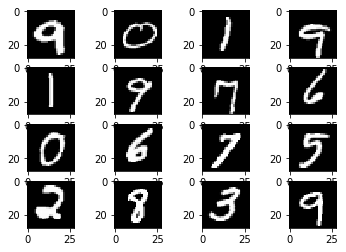

In [6]:
n=4
for i in range(n*n):
    plt.subplot(n,n,i+1)
    I = train_data['data'][np.random.randint(0, X_train.shape[0]),:]
    I = I.reshape((28, 28))
    plt.imshow(I, cmap='gray')

In [7]:
# Подготовка датасета
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from skimage.transform import rotate

X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)

sc = StandardScaler()
sc.fit(X_train)

X_train = sc.transform(X_train)
X_test = sc.transform(X_test)


X_train_train, X_train_test, Y_train_train, Y_train_test = \
    train_test_split(X_train, Y_train_oh, test_size=0.2, stratify=Y_train)

In [8]:
from skimage.transform import rotate

augemented_X_train_train = []
augemented_Y_train_train = []

for i in range(len(X_train_train)):
    augemented_X_train_train.append(X_train_train[i])
    img = X_train_train[i].reshape((28, 28))
    augemented_X_train_train.append(rotate(img, 15).flatten())
    augemented_X_train_train.append(rotate(img, -15).flatten())
    
    augemented_Y_train_train.append(Y_train_train[i])
    augemented_Y_train_train.append(Y_train_train[i])
    augemented_Y_train_train.append(Y_train_train[i])
    
augemented_X_train_train = np.vstack(augemented_X_train_train)
augemented_Y_train_train = np.vstack(augemented_Y_train_train)

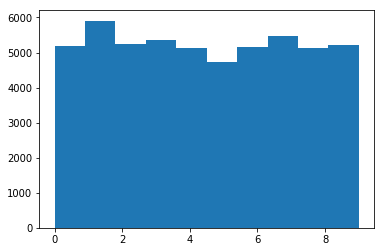

In [9]:
plt.hist(Y_train);

In [10]:
class Dense:
    def __init__(self, in_size, out_size, rlambda = 0.0):
        self.W = np.random.normal(scale=1, size=(out_size, in_size)) * np.sqrt(2 / in_size)
        self.b = np.zeros(out_size)
        self.rlambda = rlambda
        
    def forward(self, x):
        self.x = x # запоминаем для обратного прохода
        return np.dot(self.W, x) + self.b
    
    def get_reg_loss(self):
        return 0.5 * self.rlambda * (np.linalg.norm(self.W, ord='fro') ** 2)
    
    def backward(self, dz, lr=0.001):
        # вычисляем градиенты по параметрам (запоминаем их для отладки)
        self.dW = np.outer(dz, self.x)
        self.db = dz
        # вычисляем производную по входу
        self.dx = np.matmul(dz, self.W) 
        # рассчитываем градиенты от регуляризатора
        if(self.rlambda != 0):
            self.dW += self.rlambda * self.W
        # обновляем веса
        self.W = self.W - lr * self.dW
        self.b = self.b - lr * self.db
        # возвращаем dx для продолжения алгоритма
        return self.dx
    
    
class ReLU:
    
    def forward(self, x):
        self.x = x
        return np.maximum(0, x)
    
    def backward(self, dz, lr=0.1):
        dz[self.x < 0] = 0
        return dz
    
    
class Softmax:
    
    def forward(self, x):
        self.x = x
        _exp_x = np.exp(x)
        return _exp_x / np.sum(_exp_x)
        
    def backward(self, dz, lr=0.001):
        return (self.forward(self.x) * np.eye(len(self.x)) - 
                self.forward(self.x)[:, np.newaxis] @ self.forward(self.x)[np.newaxis, :]) @ dz
    
    
class CrossEntropy:
    
    def forward(self, y_true, y_hat):
        self.y_true = y_true
        self.y_hat = y_hat
        return - np.sum(y_true * np.log(y_hat))
    
    def backward(self, dz, lr=0.001):
        return - self.y_true/self.y_hat * dz
    
    
class Dropout:
    def __init__(self, p = 0.5):
        self.p = p
    
    def forward(self, x, train):
        if not train:
            self.mask = np.ones(*x.shape)
            return x
        self.mask = ( np.random.rand(*x.shape) > self.p ) / (1.0 - self.p)
        return x * self.mask
        
    def backward(self, dz, lr=0.001):
        return dz * self.mask

In [11]:
# Опеределение самой сети
class MnistNet:
    
    def __init__(self, rlambda=0.0):
        self.d1 = Dense(784, 524, rlambda)
        self.a1 = ReLU()
        self.do1 = Dropout(.4)
        self.d2 = Dense(524, 256, rlambda)
        self.a2 = ReLU()
        self.do2 = Dropout(.3)
        self.d3 = Dense(256, 256, rlambda)
        self.a3 = ReLU()
        self.do3 = Dropout(.2)
        self.d4 = Dense(256, 10, rlambda)
        self.a4 = ReLU()
        self.s = Softmax()
    
    def forward(self, x, train=True):
        net = self.d1.forward(x)
        net = self.a1.forward(net)
        net = self.do1.forward(net, train)
        net = self.d2.forward(net)
        net = self.a2.forward(net)
        net = self.do2.forward(net, train)
        net = self.d3.forward(net)
        net = self.a3.forward(net)
        net = self.do3.forward(net, train)
        net = self.d4.forward(net)
        net = self.a4.forward(net)
        net = self.s.forward(net)
        return net
    
    def backward(self, dz, lr):
        dz = self.s.backward(dz, lr)
        dz = self.a4.backward(dz, lr)
        dz = self.d4.backward(dz, lr)
        dz = self.do3.backward(dz, lr)
        dz = self.a3.backward(dz, lr)
        dz = self.d3.backward(dz, lr)
        dz = self.do2.backward(dz, lr)
        dz = self.a2.backward(dz, lr)
        dz = self.d2.backward(dz, lr)
        dz = self.do1.backward(dz, lr)
        dz = self.a1.backward(dz, lr)
        dz = self.d1.backward(dz, lr)
        return dz

In [12]:
# Здесь процедура обучения
net = MnistNet(0)
loss = CrossEntropy()
lr = 0.001
L_train = []
L_test = []
acc_train = []
acc_test = []
for iter in range(25):
    L_acc = 0.
    acc_trn = 0.0
    sh = list(range(augemented_X_train_train.shape[0])) # больше рандома богу рандома
    np.random.shuffle(sh)
    for i in range(augemented_X_train_train.shape[0]):
        x = augemented_X_train_train[sh[i]]
        y = augemented_Y_train_train[sh[i]]
        y_h = net.forward(x)
        L = loss.forward(y, y_h) #+ net.get_reg_loss()
        L_acc += L 
        acc_trn += int(np.argmax(y_h) == np.argmax(y))
        
        dz = loss.backward(1, lr)
        dz = net.backward(dz, lr)
    L_acc /= augemented_Y_train_train.shape[0]
    acc_trn /= augemented_Y_train_train.shape[0]
    acc_train.append(acc_trn)
    L_train.append(L_acc)
    
    acc_tst = 0.0
    L_e_acc = 0.
    for i in range(X_train_test.shape[0]):
        x = X_train_test[i]
        y = Y_train_test[i]
        y_h = net.forward(x, train=False)
        L = loss.forward(y, y_h) #+ net.get_reg_loss()
        L_e_acc += L
        acc_tst += int(np.argmax(y_h) == np.argmax(y))
        
    L_e_acc /= Y_train_test.shape[0]
    acc_tst /= Y_train_test.shape[0]
    L_test.append(L_e_acc)
    acc_test.append(acc_tst)
    print("Epoch#{} || Loss Train : {:.3f} | Test : {:.3f} || Accuracy Train : {:.3f} | Test : {:.3f}".
          format(iter+1, L_acc, L_e_acc, acc_trn, acc_tst))

Epoch#1 || Loss Train : 0.580 | Test : 0.179 || Accuracy Train : 0.819 | Test : 0.950
Epoch#2 || Loss Train : 0.276 | Test : 0.137 || Accuracy Train : 0.919 | Test : 0.961
Epoch#3 || Loss Train : 0.221 | Test : 0.114 || Accuracy Train : 0.933 | Test : 0.967
Epoch#4 || Loss Train : 0.189 | Test : 0.104 || Accuracy Train : 0.943 | Test : 0.970
Epoch#5 || Loss Train : 0.170 | Test : 0.096 || Accuracy Train : 0.950 | Test : 0.972
Epoch#6 || Loss Train : 0.153 | Test : 0.092 || Accuracy Train : 0.953 | Test : 0.975
Epoch#7 || Loss Train : 0.140 | Test : 0.093 || Accuracy Train : 0.958 | Test : 0.974
Epoch#8 || Loss Train : 0.132 | Test : 0.088 || Accuracy Train : 0.960 | Test : 0.976
Epoch#9 || Loss Train : 0.122 | Test : 0.082 || Accuracy Train : 0.962 | Test : 0.975
Epoch#10 || Loss Train : 0.115 | Test : 0.076 || Accuracy Train : 0.965 | Test : 0.977
Epoch#11 || Loss Train : 0.110 | Test : 0.076 || Accuracy Train : 0.966 | Test : 0.978
Epoch#12 || Loss Train : 0.103 | Test : 0.074 || Acc

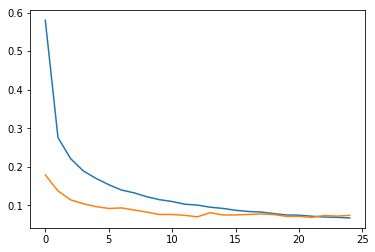

In [13]:
# Здесь необходимо отрисовать графики CrossEntropyLoss для обучающей и валидационной выборок
plt.plot(L_train, label='train')
plt.plot(L_test, label='test')

In [14]:
# формируем сабмишшен и заливаем его на kaggle
make_submission(X_test, net)